In [3]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle

In [4]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

VGG16

Computing mean distance.

Initialization for the layer in NN: 

$W_i \sim U(-\sqrt{k}, \sqrt{k})$
where $k = \frac 1 {N_{in}}$

$N_{in}$ - nubmer of input parameters for the weights. 

$N_{w}$ - numver of weights in the layer.

mean square dist between two layers in Linear layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \frac{ \left (2 \sqrt k \right )^2} {12}  = \frac {2 N_{w}} {3 N_{in}}$

for convolution layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \left (\sqrt \frac 2 {n} \right )$

where n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels

In [5]:
architecture = getattr(models, "LogRegression")

model = architecture.base(num_classes=10, **architecture.kwargs)

In [6]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

You are going to run models on the test set. Are you sure?


In [7]:
# distance for VGG16 network:
DIST = 0
i=1
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        print(i, m)
        i+=1
        N_in = m.in_channels*np.prod(m.kernel_size)
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        N_w = np.prod(m.weight.shape)
#         +np.prod(m.bias.shape)
        print('N_in', N_in)
        print('N_w', N_w)
        DIST+=2*N_w*2/n
    if isinstance(m, torch.nn.Linear):
        print(i, m)
        i+=1
        N_in = m.in_features
        N_w = np.prod(m.weight.shape)+np.prod(m.bias.shape)
        print('N_in', N_in)
        print('N_w', N_w)
        DIST+=2/3*float(N_w)/float(N_in)
        

print()        
print('Distance', (np.sqrt(DIST)))

1 Linear(in_features=784, out_features=10, bias=True)
N_in 784
N_w 7850

Distance 2.5836350493107982


In [8]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [9]:
architecture = getattr(models, "LogRegression") 
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_mnist/LogRegression/curve1/checkpoint-0.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LogRegression/curve3/checkpoint-0.pt')['model_state'])


In [10]:
def samples(model):
    p1 = list(model.parameters())[0].data.numpy()
    p2 = list(model.parameters())[1].data.numpy()
    samples = np.hstack([p1, p2[:, None]])
    
    return samples

In [11]:
list(model1.parameters())[0].shape

torch.Size([10, 784])

In [12]:
# class LogRegression(nn.Module):
#     def __init__(self, num_classes, in_dim):
#         super(LogRegression, self).__init__()
#         self.fc = nn.Linear(in_dim, num_classes)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# model2 = LogRegression(10, 784)
# model1 = LogRegression(10, 784)

In [13]:
distance(model1, model2)

2.5796747

In [14]:
2.57/(28*np.sqrt(10))

0.029025191380831192

In [15]:
S_initial1 = samples(model1)
S_initial2 = samples(model2)

In [16]:
(S_initial1*S_initial2).sum()

0.023174105

In [17]:
S_initial1.shape

(10, 785)

In [18]:
criterion = F.cross_entropy
regularizer = None 

In [19]:
model1.load_state_dict(torch.load('curves_mnist/LogRegression/curve1/checkpoint-20.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LogRegression/curve2/checkpoint-20.pt')['model_state'])

In [20]:
model1.cpu();
S1 = samples(model1)
model2.cpu();
S2 = samples(model2)

In [21]:
distance(model1, model2)

2.208001

In [22]:
# lr = 0.001
# model1.cuda()
# optimizer = torch.optim.SGD(
#     filter(lambda param: param.requires_grad, model1.parameters()),
#     lr=lr,
#     weight_decay=0.
# )

# columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
# for epoch in range(0, 10 + 1):
#     time_ep = time.time()

#     train_res = utils.train(loaders['train'], model1, optimizer, criterion, regularizer, cuda=True)
#     test_res = utils.test(loaders['test'], model1, criterion, regularizer, cuda=True)

#     time_ep = time.time() - time_ep
#     values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
#               test_res['accuracy'], time_ep]

#     table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
#     print(table)

/home/anokhin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


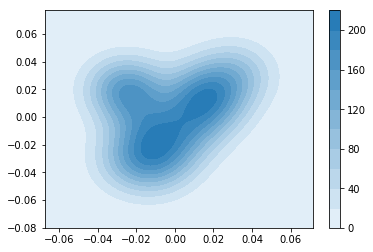

In [23]:
sns.kdeplot(S_initial1[:, 1], S_initial1[:, 2], shade=True,  cbar=True)

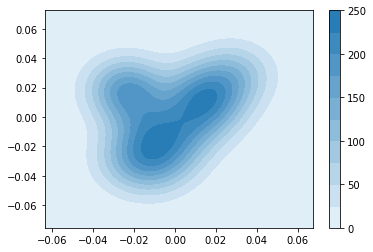

In [24]:
sns.kdeplot(S1[:, 1], S1[:, 2], shade=True,  cbar=True)

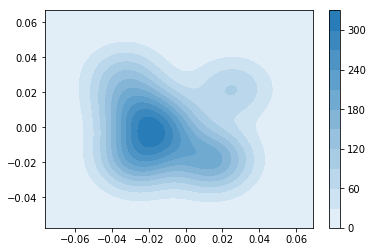

In [25]:
sns.kdeplot(S_initial2[:, 1], S_initial2[:, 2], shade=True,  cbar=True)

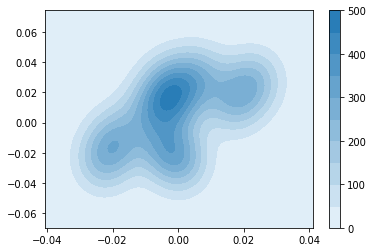

In [26]:
sns.kdeplot(S2[:, 1], S2[:, 2], shade=True,  cbar=True)

In [27]:
def get_importante_weights(S, koef=0.01):
    mask = np.zeros(785)
    mask[S[:, :].var(axis=0)>koef]=1
    mask = mask[:784].reshape((28, 28))
    return mask

In [28]:
S1.shape

(10, 785)

In [29]:
mask1 = get_importante_weights(S1, koef=0.001)
mask2 = get_importante_weights(S2, koef=0.001)

In [30]:
np.abs(mask1-mask2).sum()

16.0

In [31]:
def find_masked_distance(mask1, mask2, S_initial1, S_initial2):

    mask = mask1*mask2
    mask = mask.reshape(-1).astype(int)
    S_initial1, S_initial2 = S_initial1[:, :784], S_initial2[:, :784]
    S_initial1, S_initial2 = S_initial1[: :]*mask, S_initial2[:, :]*mask
    dx = S_initial1 - S_initial2
    distance = np.sqrt((dx*dx).sum())
    return distance

In [32]:
a = find_masked_distance(mask1, mask2, S1, S2)
a

1.7314887563334704

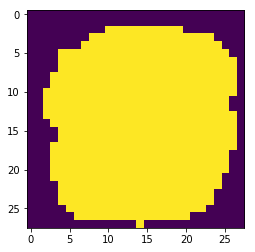

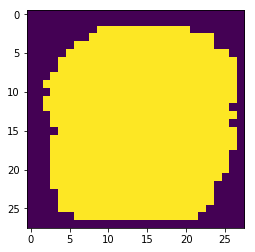

In [33]:
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)

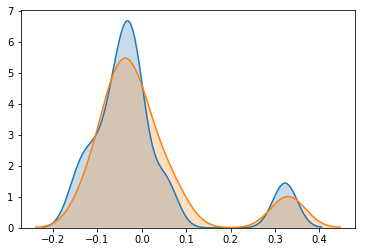

In [34]:
# оюученные распределения в 500 пикселе 1 и 2 модель
sns.kdeplot(S1[:, 500], shade=True,  cbar=True)
sns.kdeplot(S2[:, 500], shade=True,  cbar=True)

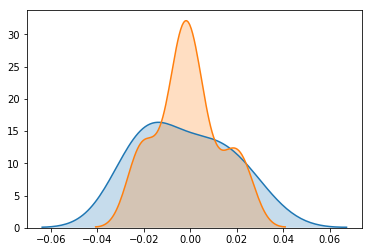

In [35]:
# оюученные распределения в 1 пикселе 1 и 2 модель
sns.kdeplot(S1[:, 1], shade=True,  cbar=True)
sns.kdeplot(S2[:, 1], shade=True,  cbar=True)

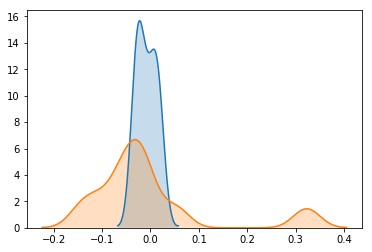

In [36]:
# оюученное и изначальные распределения в 500 пикселе 1 модель
sns.kdeplot(S_initial1[:, 500], shade=True,  cbar=True)
sns.kdeplot(S1[:, 500], shade=True,  cbar=True)

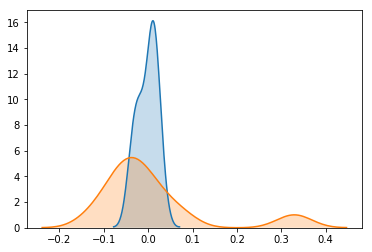

In [37]:
# оюученное и изначальные распределения в 500 пикселе 2 модель
sns.kdeplot(S_initial2[:, 500], shade=True,  cbar=True)
sns.kdeplot(S2[:, 500], shade=True,  cbar=True)

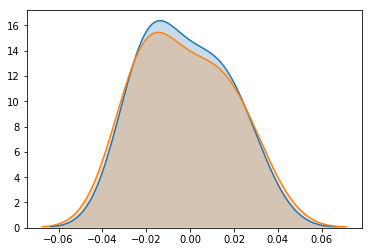

In [38]:
# оюученное и изначальные распределения в 1 пикселе 1 модель
sns.kdeplot(S1[:, 1], shade=True,  cbar=True)
sns.kdeplot(S_initial1[:, 1], shade=True,  cbar=True)

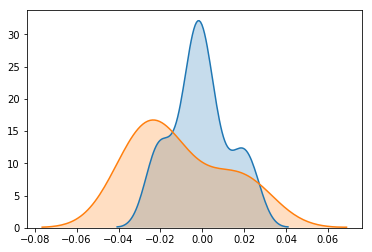

In [39]:
# оюученное и изначальные распределения в 1 пикселе 2 модель
sns.kdeplot(S2[:, 1], shade=True,  cbar=True)
sns.kdeplot(S_initial2[:, 1], shade=True,  cbar=True)

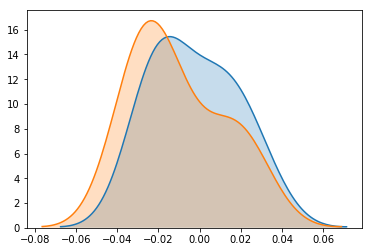

In [40]:
# изначальные распределения в 1 пикселе
sns.kdeplot(S_initial1[:, 1], shade=True,  cbar=True)
sns.kdeplot(S_initial2[:, 1], shade=True,  cbar=True)

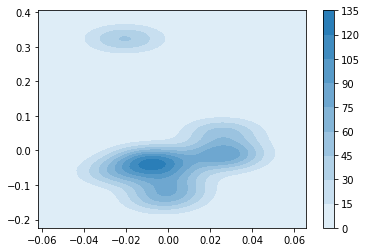

In [41]:
# совместное распределение 1 модель
sns.kdeplot(S1[:, 37], S1[:, 500], shade=True,  cbar=True)

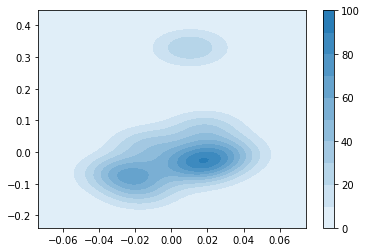

In [42]:
# совместное распределение 2 модель
sns.kdeplot(S2[:, 37], S2[:, 500], shade=True,  cbar=True)

## HeatMap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


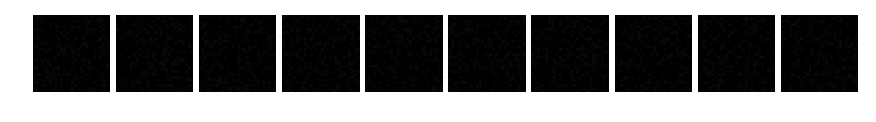

In [43]:
from matplotlib import pyplot as plt
import torchvision
%matplotlib inline

def show_images(model, scale=15, line_width=10):
    x = list(model.parameters())[0].cpu().data
    plt.figure(figsize=(scale, scale / line_width * (x.shape[0] // line_width + 1)))
    x = x.view(10, 1, 28, 28)
#     x = x-x.min()
#     print(x.max())
#     x = x/x.max()
#     print(x)
    mtx = torchvision.utils.make_grid(x, nrow=line_width, pad_value=1)
    plt.imshow(mtx.permute([1, 2, 0]).numpy(), )
    plt.axis('off')

show_images(model)

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 100

In [47]:
def heat_image(model, scale=15, line_width=10):
    
    plt.figure(figsize=(scale, scale / line_width * (10 // line_width + 1)))
    fig, ax = plt.subplots(1,10)
    ims = list(model.parameters())[0].cpu().data.numpy()
    for ind, im in enumerate(ims):
        im = np.abs(im.reshape((28, 28)))

        ax[ind].imshow(im)
        ax[ind].set_title(ind)
        
#     plt.colorbar()
#     plt.axis('off')
    plt.show()

<Figure size 1500x300 with 0 Axes>

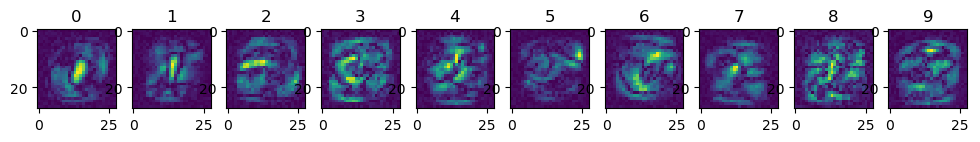

<Figure size 1500x300 with 0 Axes>

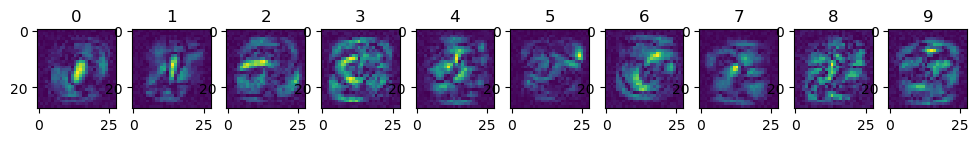

In [48]:
heat_image(model1)
heat_image(model2)

In [44]:
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 50

In [50]:
(pr_im2*pr_im1).sum()/(np.sqrt((pr_im2*pr_im2).sum())*np.sqrt((pr_im1*pr_im1).sum()))

0.9782116

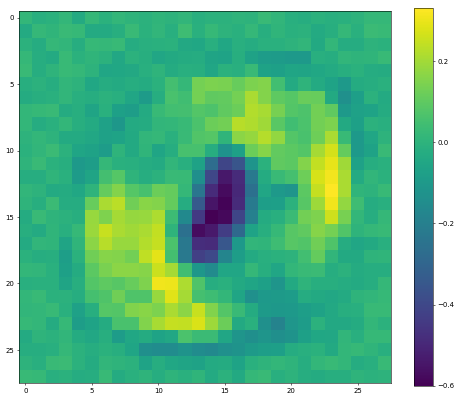

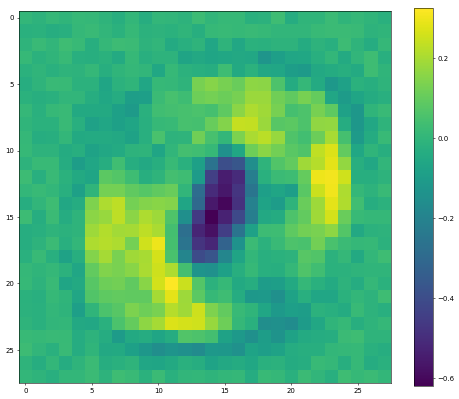

In [45]:
pr_im1 = list(model1.parameters())[0].cpu().data.numpy()[0]
pr_im2 = list(model2.parameters())[0].cpu().data.numpy()[0]

# im1 = np.abs(im1.reshape((28, 28)))
# im2 = np.abs(im2.reshape((28, 28)))

im1 = pr_im1.reshape((28, 28))
im2 = pr_im2.reshape((28, 28))

plt.imshow(im1)
plt.colorbar()
plt.show()
plt.imshow(im2)
plt.colorbar()
plt.show()

In [303]:
i, j = 20, 10 
im1[i][j], im2[i][j]

(0.3093808, 0.25955367)

In [2]:
dx = im1-im2
distance = np.sqrt((dx*dx).sum())/28
distance

NameError: name 'im1' is not defined

In [4]:
0.73/28

0.026071428571428572

In [1]:
import numpy as np
np.sqrt(0.73**2*10)

2.3084626919229168